In [72]:
import pandas as pd
import numpy as np
import math
import io
import random
random.seed(1)
from matplotlib import pyplot as plt

import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

## Importing the dataset
Our dataset contains images of the **HAM10000** dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset is stored as a CSV-file

In [71]:
from google.colab import files
 
# Load dataset
# Upload neccesary to run the NN on Colab
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['hmnist_28_28_L.csv']))

# Run the following line if the dataset can be loaded locally
# df = pd.read_csv(r'data/hmnist_28_28_L.csv')

Saving hmnist_28_28_L_pcaRed.csv to hmnist_28_28_L_pcaRed (2).csv
Saving hmnist_28_28_L.csv to hmnist_28_28_L (2).csv


## Partitioning the dataset into training and testing data

In [85]:
images = df.to_numpy()
num_images = np.size(images, axis=0) # Number of data images in total
dim = int(math.sqrt(np.size(images[0]))) # Side lengths of the images

# Hyperparameters
split_index = 9000 # The index at which the dataset is being partitioned


# Randomly rearrange the order of the images
img_perm = np.random.permutation(images)
# The image labels
labels = img_perm[:, -1]
# The images themselves
img_perm = img_perm[:, 0:-1]
img_perm = np.reshape(img_perm, (num_images, dim, dim, 1)) # Shape: (#images, dim, dim, 1)

# Training data
train_labels = labels[:split_index]
train_imgs = img_perm[:split_index].transpose((0, 3, 1, 2))

test_labels = labels[split_index:]
test_imgs = img_perm[split_index:].transpose((0, 3, 1, 2))

## Constructing the neuronal network

In [86]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2, bias=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2, bias=True)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2, bias=True)

        self.fc1 = nn.Linear(128*3*3, 1024)
        self.dropl = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 7)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropl(x)
        x = self.fc2(x)

        return x

# Print net
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (dropl): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=7, bias=True)
)


## The training function

In [87]:
def train(tdata, tlabel, net, to_train):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist=[]
    
    # Hyperparameters
    epochs = 25
    batch = 200
    learning_rate = 1e-3
    optimizer = optim.Adam(to_train, lr=learning_rate)
    
    for k in tqdm(range(epochs)):
        for l in range(int(len(tdata) / batch)):
            inds = np.random.randint(0, len(tdata)-1, batch)
            inputs = Variable(torch.FloatTensor(tdata[inds]).cuda())
            targets = Variable(torch.LongTensor(tlabel[inds]).cuda())
            
            # Zero grad optimizer
            optimizer.zero_grad()
            # Forward propagation
            pred = net(inputs)
            loss = criterion(pred, targets)
            # Backpropagation
            loss.backward()
            optimizer.step()
            acc = np.mean(np.argmax(pred.data.cpu().numpy(),1) == tlabel[inds])

            loss = loss.detach().cpu().numpy()
            losslist.append(loss)
            acclist.append(acc)

    return losslist, acclist

def test(tdata, tlabel, net):
    inputs = Variable(torch.FloatTensor(tdata).cuda())
    targets = Variable(torch.LongTensor(tlabel).cuda())
    prediction = net(inputs)
    acc = np.mean(np.argmax(prediction.data.cpu().numpy(),1) == tlabel)

    return acc

## Training the model

100%|██████████| 25/25 [00:11<00:00,  2.22it/s]


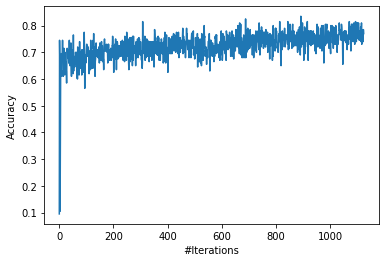

Accuracy: 0.6729064039408867


In [77]:
net = Net().cuda()
_, acc = train(train_imgs, train_labels, net, net.parameters())
ax = range(len(acc))
plt.plot(ax, acc)
plt.xlabel('#Iterations')
plt.ylabel('Accuracy')
plt.show()
print('Accuracy: {}'.format(test(test_imgs, test_labels, net)))

# Now do the same with the dataset where PCA has been performed

In [88]:
pca = pd.read_csv(io.BytesIO(uploaded['hmnist_28_28_L_pcaRed.csv'])).to_numpy()

# Randomly rearrange the order of the images
pca_perm = np.random.permutation(pca)
# The image labels
pca_labels = pca_perm[:, -1]
# The images themselves
pca_perm = pca_perm[:, 0:-1]
pca_perm = np.reshape(pca_perm, (num_images, dim, dim, 1)) # Shape: (#images, dim, dim, 1)

# Training data
pca_train_labels = pca_labels[:split_index]
pca_train_imgs = pca_perm[:split_index].transpose((0, 3, 1, 2))

pca_test_labels = pca_labels[split_index:]
pca_test_imgs = pca_perm[split_index:].transpose((0, 3, 1, 2))

100%|██████████| 25/25 [00:11<00:00,  2.21it/s]


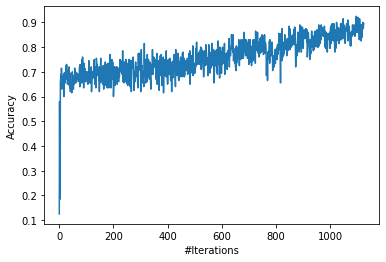

Accuracy: 0.7940886699507389


In [84]:
net2 = Net().cuda()
_, acc2 = train(pca_train_imgs, pca_train_labels, net2, net2.parameters())
ax = range(len(acc2))
plt.plot(ax, acc2)
plt.xlabel('#Iterations')
plt.ylabel('Accuracy')
plt.show()
print('Accuracy: {}'.format(test(pca_test_imgs, pca_test_labels, net2)))